In [21]:
from IPython.display import HTML

HTML('''<script>
            code_show=true; 
            function code_toggle(){
                if (code_show)
                     {$('div.input').hide();} 
                else 
                     {$('div.input').show();}
                code_show = !code_show} 
            $(document).ready(code_toggle);
        </script>
        
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

## Load lib

In [22]:
%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
import scipy.constants as const
from si_prefix import si_format
from tqdm import tqdm, tqdm_notebook

import pandas as pd
import numpy as np
from io import StringIO 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

pd.set_option("display.precision", 3)
plt.close('all')

import sys 
sys.path.append('..')
# from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

In [24]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34, Nser = 16, Npar = 2):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 ) /Nser *Npar
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /(RN/Nser*Npar)
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = np.sqrt(2 *const.e *IAB *2*const.pi /const.h /C_JJ) /2/const.pi
    Q = freqPlasma*2*np.pi *RN *C_JJ
    EJoEc = EJ_JJ/EC_JJ

    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',   '$\omega_p$', 'Q', 'beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM = pd.DataFrame( data = list(zip(*lst)),      index = key ).transpose()
    JJparUNI = pd.DataFrame( data = dict(zip(key, unit)), index = [0] )

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    return epsilon *area /dielecTHK

# database

In [25]:
key =    [ 'Device' ,  'Vo/al', 'RN/al',   'ISW' , 'R0ZF' , 'R0FF' , '#ser', '#par', 'Mat.',  'BT' , 'dsgn', 'J size']
unit=    ['       ' ,      'V',   'ohm',     'A' ,  'ohm' ,  'ohm' ,   'ea',   'ea',     '',   'K' ,     '',    'm^2']
lst =   [['53N2  '  , 1.610e-3, 9.376e3,    9e-8 ,  np.nan,  np.nan,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['55B1N9'  , 1.675e-3, 1.152e5, 1.53e-10, 1.006e6, 6.668e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['59B6N3'  , 1.875e-3, 8.438e4, 1.98e-9 , 7.883e4, 2.591e7,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['59B0N1'  , 2.178e-4, 8.756e3,  3.9e-9 , 1.314e3, 1.650e9,     2 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['59BBN2'  , 1.385e-3, 1.754e6,  3.2e-13, 2.367e8, 9.032e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['62B3N2'  , 2.495e-3, 9.935e5,  2.1e-11, 4.319e6, 8.931e8,    20 ,      2,   'Al', 0.045 ,  'Fin', 0.04e-12],
         ['60B2N6'  , 3.345e-3, 6.647e5,  1.2e-12, 2.292e7, 9.587e8,    20 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['60B2N2'  , 3.186e-4, 1.199e5, 2.68e-12, 2.909e7, 9.209e8,     4 ,      2,   'Al', 0.030 ,  'Fin', 0.04e-12],
         ['63BAN6_b', 5.010e-3, 5.942e5,  2.0e-11, 7.715e6, 9.350e8,    30 ,      2,   'Al', 0.030 ,  'x_s', 0.04e-12],
         ['63BAN6_a', 3.070e-3, 5.859e5,  2.2e-11, 2.650e5, 1.380e7,    30 ,      2,   'Al', 0.030 ,  'x_s', 0.04e-12],
         ['66B8N5_b', 1.720e-3, 6.613e4,  5.4e-9 , 8.510e2, 1.463e8,    30 ,      2,   'Al', 0.030 ,  'x_s', 0.04e-12],
         ['70B1N0'  ,   np.nan, 1.682e5,  1.6e-10, 2.373e4,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L',    4e-12],
         ['79N6'    , 1.645e-4, 1.458e3, 1.37e-7 ,  2.20e0,  np.nan,     1 ,      2,   'Al', 0.030 ,  'x_L', 3.74e-12],
         ['79N5'    , 2.021e-3, 2.335e4,  5.6e-9 , -3.07e2,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L', 3.74e-12],
         ['74N4'    , 1.972e-3, 1.350e4,  9.0e-8 ,  1.00e0,  np.nan,     9 ,      2,   'Al', 0.030 ,  'x_L', 2.25e-12],
         ['78N0'    , 1.931e-3, 2.542e5, 3.71e-11,  1.00e4,  np.nan,    15 ,      2,   'Al', 0.030 ,  'x_L',    4e-12],
         ['78N5'    , 9.685e-5, 1.670e4,  8.0e-10,  1.00e5,  np.nan,     1 ,      2,   'Al', 0.030 ,  'x_L',    4e-12]]
         
Q1Dlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
Q1Duni =   dict(zip(key, unit))

lst = []
for i in range(0,16+1):
    JJwidthUM = np.sqrt(Q1Dlst.iloc[i]['J size']*1e12)
    JJpd = JJpar(  RN = Q1Dlst.iloc[i]['RN/al'], JJwidthUM=JJwidthUM, metalTHK=250E-10, Tc=1.34, 
                 Nser = Q1Dlst.iloc[i]['#ser'] , Npar = Q1Dlst.iloc[i]['#par'])[0]
    
    JJpd = np.flip(JJpd.values[0]).tolist()
    JJpd += [Q1Dlst.iloc[i]['Device']]
    JJpd = np.flip(np.asarray(JJpd))
    lst.append(JJpd)
    
key =    [ 'Device' ,  'RN_JJ', 'Rs/JJ',   'I_AB' , 'EJ' , 'C_JJQP' , 'EC', '$\omega_p$', 'Q',     'beta' , 'EJ/EC']
unit=    ['       ' ,   'kohm',  'kohm',     'nA' ,  'K' ,     'fF' ,  'K',        'GHz',  '',         '' ,      '']
JJplst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
JJpuni =   dict(zip(key, unit))
JJplst

,Device,RN_JJ,Rs/JJ,I_AB,EJ,C_JJQP,EC,$\omega_p$,Q,beta,EJ/EC
53N2,53N2,9.376,0.04688,341.2545094911551,8.134503219985833,2.0000000000000004,0.46481234851830844,114.59784459505063,13.502180580125636,182.30888041832185,17.50061771361357
55B1N9,55B1N9,115.2,0.5759999999999998,27.774325355807896,0.6620581787377358,2.0000000000000004,0.46481234851830844,32.69331877824153,47.32834871586487,2239.972592170508,1.4243558305802155
59B6N3,59B6N3,84.38,0.42189999999999994,37.91896516934191,0.9038765369825451,2.0000000000000004,0.46481234851830844,38.200186931750785,40.505581676341585,1640.7021469387792,1.9446052581517044
59B0N1,59B0N1,8.756,0.43779999999999997,36.541825959217334,0.8710495910300041,2.0000000000000004,0.46481234851830844,37.500095368107,4.126178284686472,17.025347237018195,1.873981174998182
59BBN2,59BBN2,1754.0,8.77,1.8241746185798575,0.043482954498624375,2.0000000000000004,0.46481234851830844,8.378580644500232,184.67576520030536,34105.13825231832,0.09354948214529123
62B3N2,62B3N2,993.5,4.967499999999999,3.220535763451505,0.07676809480683157,2.0000000000000004,0.46481234851830844,11.13272068441026,138.98855775500982,19317.819186817702,0.16515932731035815
60B2N6,60B2N6,664.7,3.3235,4.813603551961893,0.11474214260657012,2.0000000000000004,0.46481234851830844,13.610447643838766,113.6862528188774,12924.564079997712,0.2468569154247643
60B2N2,60B2N2,119.9,2.9974999999999996,5.337118066704037,0.12722118797429052,2.0000000000000004,0.46481234851830844,14.331467228888403,21.593333984625993,466.27207257160387,0.2737044064767987
63BAN6_b,63BAN6_b,594.2,1.9806666666666661,8.077084182907447,0.19253391667095376,2.0000000000000004,0.46481234851830844,17.63049697167039,131.64581755425252,17330.62127952754,0.41421859226567015
63BAN6_a,63BAN6_a,585.9,1.9529999999999998,8.191506095722145,0.19526139833739672,2.0000000000000004,0.46481234851830844,17.754936736094017,130.72314603098522,17088.540908238287,0.42008651224485616


In [26]:
key =    [ 'Device' ,  'Vo/al', 'RN/al',   'ISW' , 'R0ZF' , 'R0FF' , '#ser', '#par', 'Mat.',  'BT' , 'J size',  'EC']
unit=    ['       ' ,      'V',   'ohm',     'A' ,  'ohm' ,  'ohm' ,   'ea',   'ea',     '',   'K' ,    'm^2',   'K']
lst =   [['PhC_01'  ,   np.nan,  289800,   11e-12,  np.nan,  np.nan,    63 ,      2,   'Al', 0.030 , 0.07e-12, 0.267],
         ['PRB_90'  ,   np.nan,   30000,  1.1e-9 ,    12e3,  np.nan,     1 ,      1,   'Nb', 1.270 ,  0.4e-12, 0.046],
         ['IEE_87'  ,   np.nan,   66670,  1.3e-9 ,     6e3,  np.nan,     1 ,      1,   'Nb', 0.010 ,  0.2e-12, 0.092],
         ['PRB_86'  ,   np.nan,     168,  0.5e-6 ,  np.nan,  np.nan,     1 ,      1,   'Sn', 1.710 ,  3.0e-12, 0.006],
         ['PRL_87'  ,   np.nan,   70000,  1.2e-9 ,     1e3,  np.nan,     1 ,      1,   'Sn', 0.023 , 0.02e-12, 0.928],
         ['JLT_11'  ,   np.nan,     828,  290e-9 ,  np.nan,  np.nan,     1 ,      1,   'Al', 0.050 ,   65e-12,2.8e-4],
         ['STh_13'  ,   np.nan,    2700,   10e-9 ,     130,  np.nan,     1 ,      1,   'Al', 0.017 ,  0.4e-12, 0.046],
         ['PRB_89'  ,   np.nan,  140000,   10e-9 ,    7000,  np.nan,     1 ,      1,   'Sn', 0.020 , 0.02e-12, 0.928],                
         ['NJP_13'  ,   np.nan,  235950,  np.nan ,     400,  np.nan,  2888 ,      1,   'Al', 0.020 ,0.018e-12, 1.030],
         ['PRL_01'  ,   np.nan,   17000,  np.nan ,     400,  np.nan,     1 ,      1,   'Al', 0.020 , 0.04e-12, 0.464],
         ['JPc_03'  ,   np.nan,  561000,   50e-9 ,     357,  np.nan,   255 ,      1,  'Al2', 0.040 , 0.07e-12, 0.265],
         ['PhB_00'  ,   np.nan, 1377000,  np.nan ,    1000,  np.nan,   255 ,      1,  'Al2', 0.040 , 0.07e-12, 0.265],
         ['PRL_06'  ,   np.nan,    2800,  np.nan ,     1e7,  np.nan,     1 ,      1,  'Al2', 0.050 ,0.036e-12, 0.522],
         ['PRL_05'  ,   np.nan,    1300,7.285e-8 ,  np.nan,  np.nan,     1 ,      2,  'Al2', 0.038 ,    1e-12, 0.019],
         ['PRL_05'  ,   np.nan, 1087750,  np.nan ,  np.nan,  np.nan,   250 ,      1,   'Al', 0.020 ,  200e-12, 0.946],
         
        ]
    
LTRlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
LTRuni =   dict(zip(key, unit))

Tcdic = {'Nb' : 9,
         'Al' : 1.34,
         'Sn' : 3.72,
        'Al2' : 1.12}
lst = []
l = len(LTRlst['Device'])
for i in range(0,l):
    JJwidthUM = np.sqrt(LTRlst.iloc[i]['J size']*1e12)
    JJlpd = JJpar(  RN = LTRlst.iloc[i]['RN/al'], JJwidthUM=JJwidthUM, metalTHK=250E-10, Tc = Tcdic[LTRlst['Mat.'][i]], 
                  Nser = LTRlst.iloc[i]['#ser'] , Npar = LTRlst.iloc[i]['#par'])[0]
    JJlpd = np.flip(JJlpd.values[0]).tolist()
    JJlpd += [LTRlst.iloc[i]['Device']]
    JJlpd = np.flip(np.asarray(JJlpd))
    lst.append(JJlpd)
 
key =    [ 'Device' ,  'RN_JJ', 'Rs/JJ',   'I_AB' , 'EJ' , 'C_JJQP' , 'EC', '$\omega_p$', 'Q',  'beta' , 'EJ/EC']
unit=    ['       ' ,   'kohm',  'kohm',     'nA' ,  'K' ,     'fF' ,  'K',        'GHz',  '',      '' ,      '']
JJlplst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
JJlpuni =   dict(zip(key, unit))
JJlplst

,Device,RN_JJ,Rs/JJ,I_AB,EJ,C_JJQP,EC,$\omega_p$,Q,beta,EJ/EC
PhC_01,PhC_01,289.8,0.7657045603089713,34.778285662924674,0.8290119803324691,3.500000000000001,0.2656070562961762,27.654913896598774,176.24573023235592,31062.55742513638,3.121197124401864
PRB_90,PRB_90,30.0,12.948683298050513,71.63288688781499,1.7075172132221004,20.000000000000004,0.04648123485183085,16.60326412903218,62.59283113605412,3917.8625096265864,36.73562500362107
IEE_87,IEE_87,66.67,14.82478652059911,32.23318744014473,0.7683443287335083,9.999999999999998,0.09296246970366172,15.750845606115904,65.98028664139065,4353.398225280073,8.265102370696201
PRB_86,PRB_86,0.168,0.5185492267835784,5287.189270291106,126.03103240448837,150.0,0.006197497980244114,52.08576496233212,8.247065730738269,68.01409316711754,20335.792412718805
PRL_87,PRL_87,70.0,1.894974746830583,12.689254248698656,0.302474477770772,1.0,0.9296246970366171,31.25145897739927,13.745109551230449,188.92803657532653,0.32537267860350083
JLT_11,JLT_11,0.828,54.153777470779545,386.42539625471863,9.211244225916325,3249.9999999999995,0.0002860383683189591,3.0251255079982973,51.14897837212046,2616.2179885116466,32202.827473987472
STh_13,STh_13,2.7,1.1653814968245462,118.50378818478036,2.8247815626143393,20.000000000000004,0.04648123485183085,21.355186401291544,7.245644045148523,52.49935762899624,60.77251543808918
PRB_89,PRB_89,140.0,3.789949493661166,6.344627124349328,0.151237238885386,1.0,0.9296246970366171,22.098118564892232,19.438520343654066,377.856073150653,0.16268633930175042
NJP_13,NJP_13,235.95,0.0020186636834741084,3916.2752225032573,93.35247600187148,0.9000000000000002,1.0329163300406854,578.7188059735219,772.1647198324775,596238.3545539685,90.37757782200464
PRL_01,PRL_01,17.0,0.85,18.821189888171,0.44864177759168916,2.0000000000000004,0.46481234851830844,26.912917987590905,5.749360929680654,33.05515109973839,0.9652105393108282


In [27]:
key =    [    'Device' ,    'BT',  'EJ',  'EC']
unit=    ['          ' ,     'K',   'K',   'K']
lst =   [['Charge Qbit',   0.030, 0.601, 1.357],
         ['Flux Qbit'  ,   0.035, 4.799, 0.576],
         ['Tansmon'    ,   0.035, 0.837, 0.019],
         ['Fluxonium'  ,  0.035, 0.144, 0.040],
         ['Bifluxon'   ,   0.035, 1.305, 0.370]]
Qbtlst =   pd.DataFrame(  data  = list(zip(*lst)), 
                        columns = [[dev[i] for dev in lst] for i in range(len(lst[0]))][0],
                          index = key ).transpose()
Qbtuni =   dict(zip(key, unit))
Qbtlst

,Device,BT,EJ,EC
Charge Qbit,Charge Qbit,0.03,0.601,1.36
Flux Qbit,Flux Qbit,0.035,4.8,0.576
Tansmon,Tansmon,0.035,0.837,0.019
Fluxonium,Fluxonium,0.035,0.144,0.04
Bifluxon,Bifluxon,0.035,1.3,0.37


# Plots

<IPython.core.display.Javascript object>


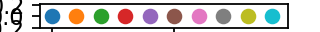

<IPython.core.display.Javascript object>


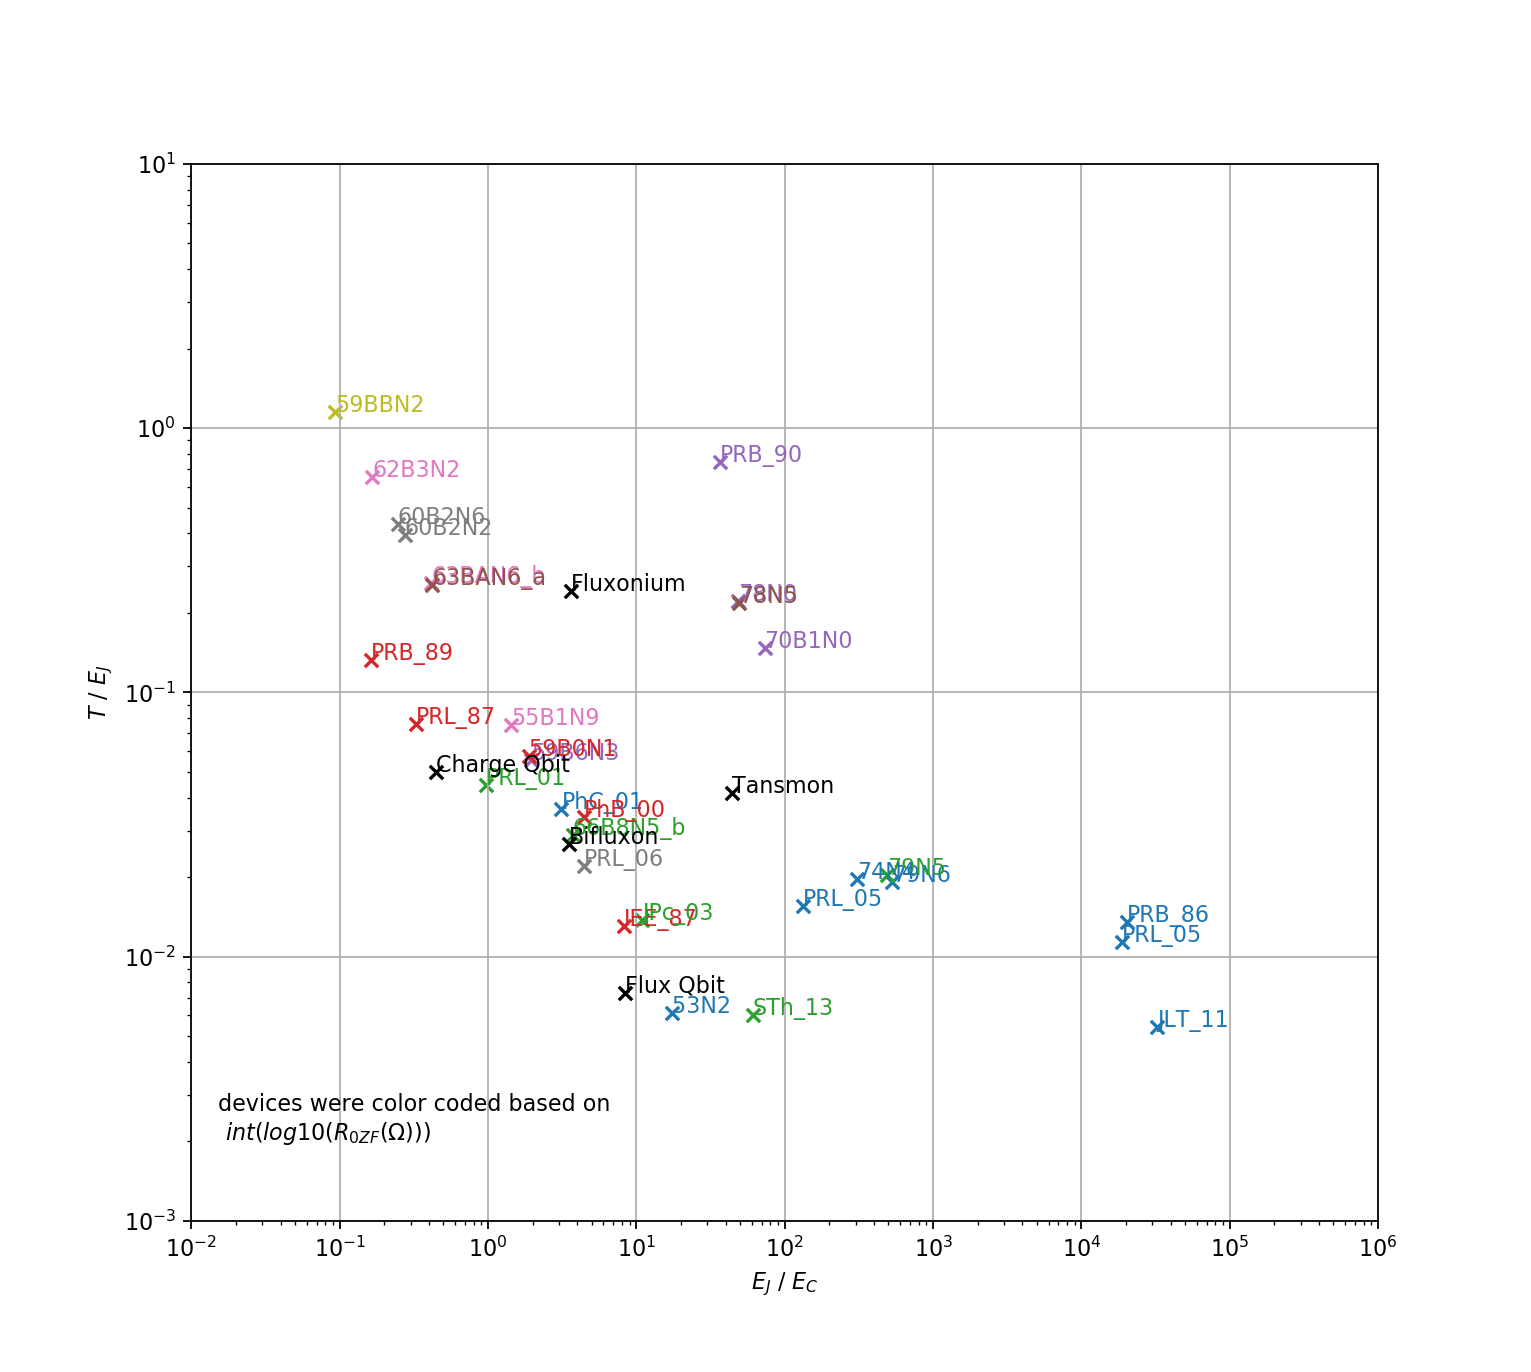

(0.001, 10.0)

In [38]:
f,ax=plt.subplots(figsize=(2,.2))
for i in range(10):
    ax.scatter([i], [0], color = 'C'+str(i))
    
f,ax = plt.subplots()

EJ = JJplst['EJ'].astype(float)
EC = JJplst['EC'].astype(float)
T = [50e-3]*len(JJplst['EJ'])
R0 = Q1Dlst['R0ZF']

n = JJplst['Device']
for i, txt in enumerate(n):
    if np.isfinite(R0.tolist()[i]):
        color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
    else:
        color = 'C0'
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = color)
    ax.annotate(txt, (x[0], y[0]), color = color)
    

EJ = JJlplst['EJ'].astype(float)
EC = JJlplst['EC'].astype(float)
T = LTRlst['BT']
R0 = LTRlst['R0ZF']

n = JJlplst['Device']
for i, txt in enumerate(n):
    if np.isfinite(R0.tolist()[i]):
        color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
    else:
        color = 'C0'
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = color, label = 'R0:1E{}'.format(color[1:2]))
    ax.annotate(txt, (x[0], y[0]), color = color)    

EJ = Qbtlst['EJ'].astype(float)
EC = Qbtlst['EC'].astype(float)
T = Qbtlst['BT'].astype(float)
n = Qbtlst['Device']
for i, txt in enumerate(n):
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = 'black')
    ax.annotate(txt, (x[0], y[0]), color = 'black')    

ax.text(0.015,0.002,'devices were color coded based on \n $int(log10(R_{0ZF}(\Omega)))$')
    
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_J$ / $E_C$')
ax.set_ylabel('$T$ / $E_J$')
ax.set_xlim(1e-2, 1e+6)
ax.set_ylim(1e-3, 1e+1)

<IPython.core.display.Javascript object>


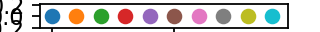

<IPython.core.display.Javascript object>


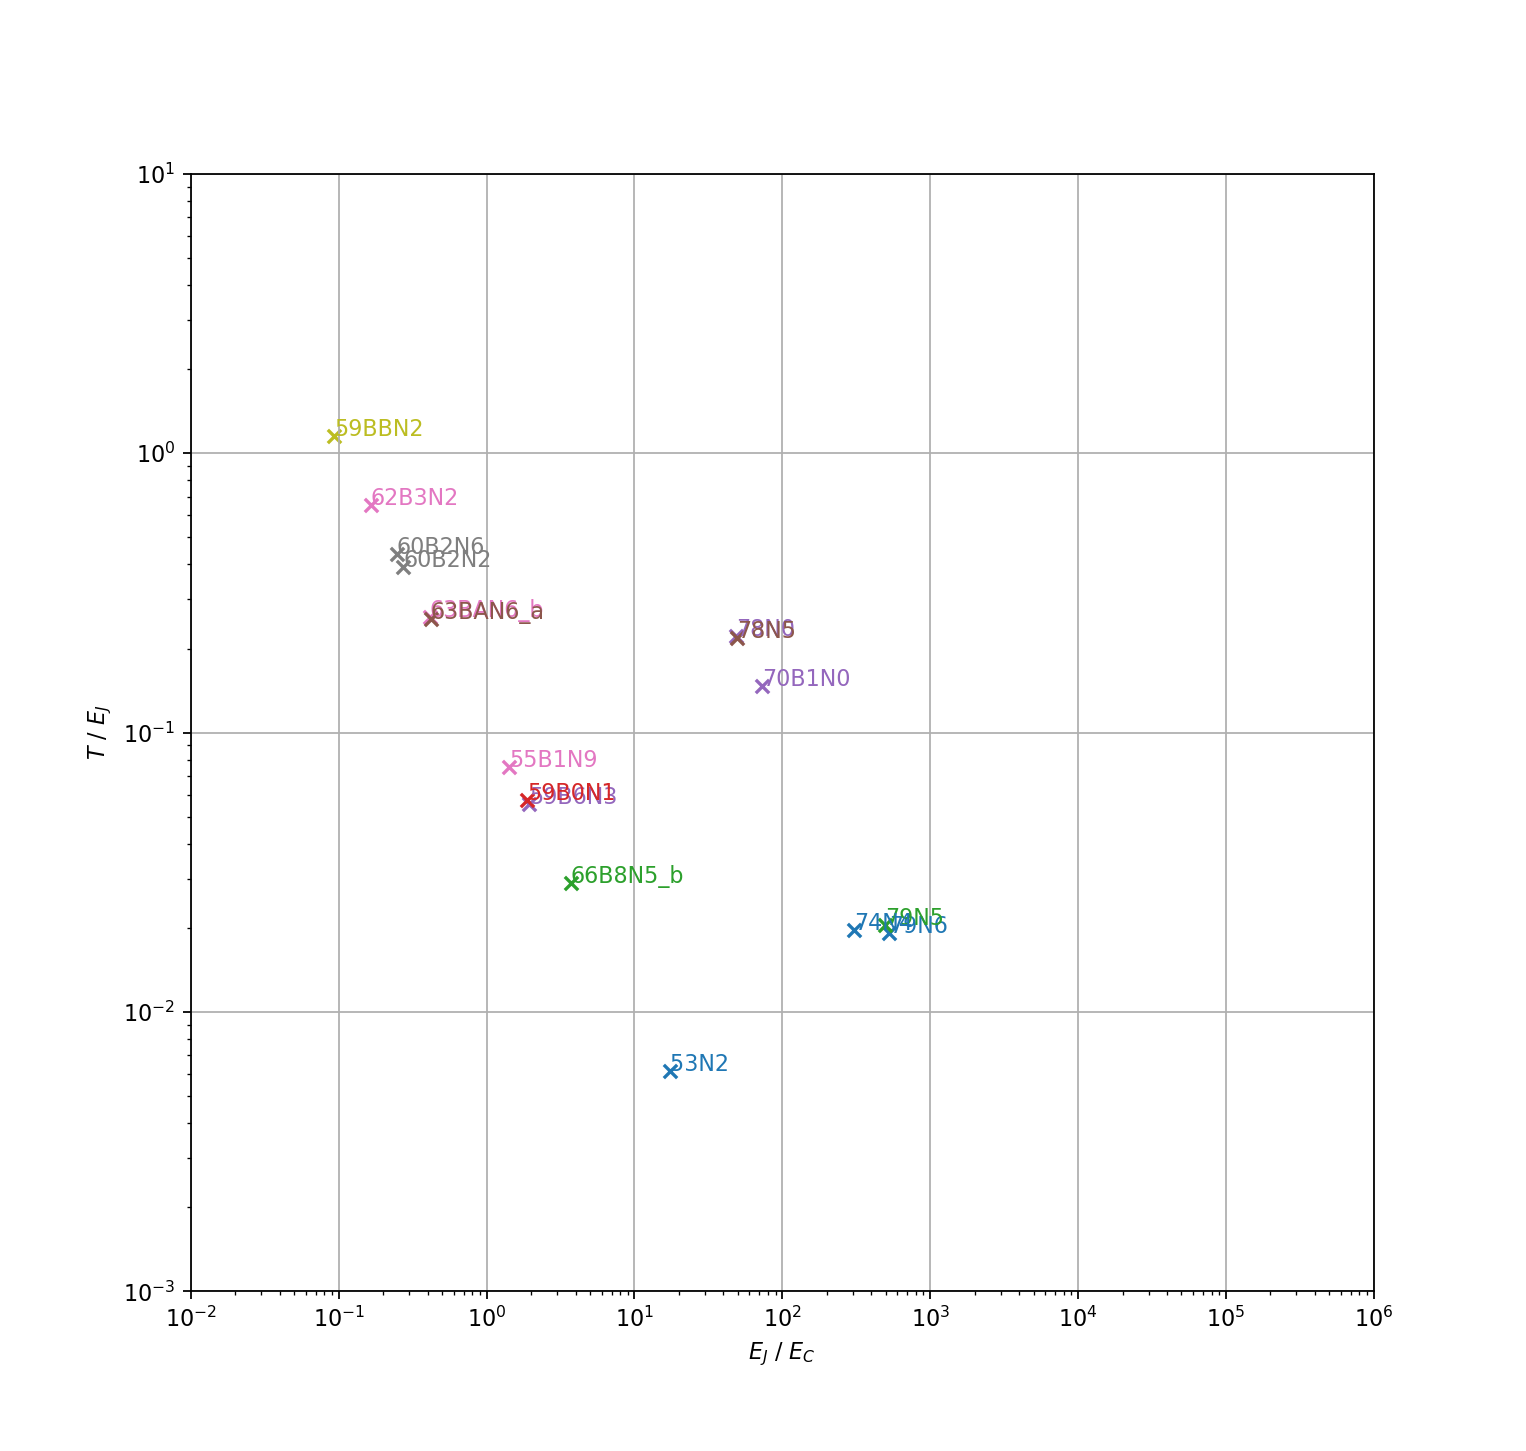

(0.001, 10.0)

In [44]:
f,ax=plt.subplots(figsize=(2,.2))
for i in range(10):
    ax.scatter([i], [0], color = 'C'+str(i))
    
f,ax = plt.subplots()

EJ = JJplst['EJ'].astype(float)
EC = JJplst['EC'].astype(float)
T = [50e-3]*len(JJplst['EJ'])
R0 = Q1Dlst['R0ZF']

n = JJplst['Device']
for i, txt in enumerate(n):
    if np.isfinite(R0.tolist()[i]):
        color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
    else:
        color = 'C0'
    x = [(EJ/EC)[i]]
    y = [( T/EJ)[i]]
    ax.scatter(x, y, marker = 'x', color = color)
    ax.annotate(txt, (x[0], y[0]), color = color)
    

# EJ = JJlplst['EJ'].astype(float)
# EC = JJlplst['EC'].astype(float)
# T = LTRlst['BT']
# R0 = LTRlst['R0ZF']

# n = JJlplst['Device']
# for i, txt in enumerate(n):
#     if np.isfinite(R0.tolist()[i]):
#         color = 'C'+ str(int(np.log10(np.abs(R0.tolist()[i]))))
#     else:
#         color = 'C0'
#     x = [(EJ/EC)[i]]
#     y = [( T/EJ)[i]]
#     ax.scatter(x, y, marker = 'x', color = color, label = 'R0:1E{}'.format(color[1:2]))
#     ax.annotate(txt, (x[0], y[0]), color = color)    

# EJ = Qbtlst['EJ'].astype(float)
# EC = Qbtlst['EC'].astype(float)
# T = Qbtlst['BT'].astype(float)
# n = Qbtlst['Device']
# for i, txt in enumerate(n):
#     x = [(EJ/EC)[i]]
#     y = [( T/EJ)[i]]
#     ax.scatter(x, y, marker = 'x', color = 'black')
#     ax.annotate(txt, (x[0], y[0]), color = 'black')    

# # ax.text(0.015,0.002,'devices were color coded based on \n $int(log10(R_{0ZF}(\Omega)))$')
    
ax.grid('on')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_J$ / $E_C$')
ax.set_ylabel('$T$ / $E_J$')
ax.set_xlim(1e-2, 1e+6)
ax.set_ylim(1e-3, 1e+1)

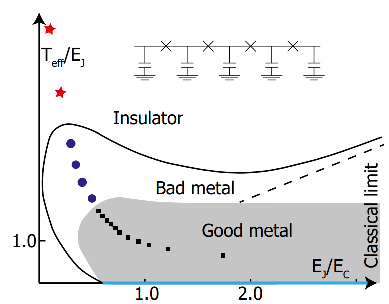

In [16]:
display(Image(filename=r'C:\Users\racco\Documents\QCoDes\measDC\experimental log toolbox\img\20225-154245.png'))

<IPython.core.display.Javascript object>


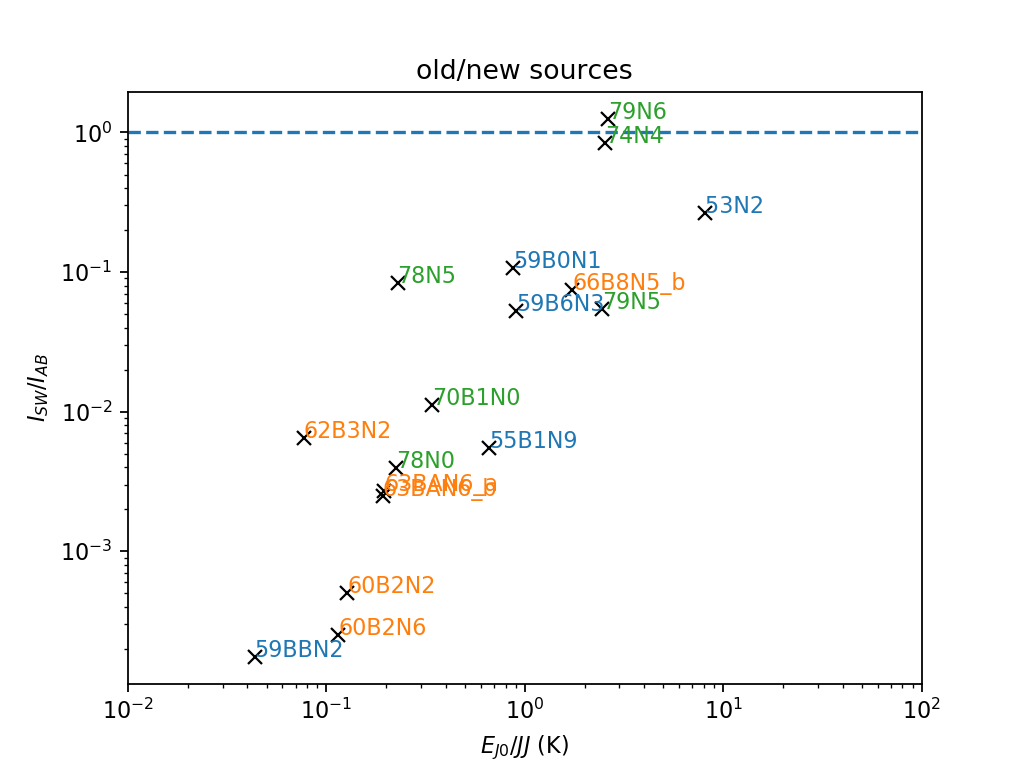

(0.01, 100)

In [39]:
f,ax = plt.subplots()
ax.plot(JJplst['EJ'].astype(float), Q1Dlst['ISW']/1e-9/JJplst['I_AB'].astype(float), marker = 'x', ls = 'None', color = 'black')

n = Q1Dlst['Device']
for i, txt in enumerate(n):
    if int(Q1Dlst['Device'][i][:2]) < 60:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C0')
    elif 60 <= int(Q1Dlst['Device'][i][:2]) < 70:
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C1')
    elif 70 <= int(Q1Dlst['Device'][i][:2]):
        ax.annotate(txt, (JJplst['EJ'].astype(float)[i], (Q1Dlst['ISW']/1e-9/JJplst['I_AB'].astype(float))[i]),
                    color='C2')
        
ax.axhline(1e0,ls = '--')
ax.set_title('old/new sources')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_{J0} / JJ$ (K)')
ax.set_ylabel('$I_{SW} / I_{AB}$')
ax.set_xlim(0.01,100)

# Slides

## P0: Outline

## P1: Motivation and theoretical interests

- Pave the path to MBL studies
- Regimes that has yet been studied

## P2: Literature study: parameters space  

## P3: Experimental details: verify EC, T, and EJ
- BT: through I_SW statistics
- EC: through capacitance bridge, through V_offset, through MW resonances?

## P4: Verify EJ with ISW

## P5: Applicable freq range?

## P6: 

## P7: 

## P8: 

## P9: Summary